### Import packages

In [1]:
import pandas as pd; import os; from analysis_helpers import *; import warnings
from analysis_helpers import *
warnings.filterwarnings('ignore')
import seaborn as sb
import numpy as np
from scipy.interpolate import pchip
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import pingouin

### Load data

In [2]:
b     = pd.read_csv('behavioral.csv') 
d_nov = pd.read_csv('d_nov_MEM_mg_new_b.csv')

### Add last-cued category to memory trials

In [3]:
for idx,x in b[(b['Trial']==9)&(b['Trial Type']=='Presentation')].iterrows():
    b.loc[(b['UniqueID']==x['UniqueID']) &(b['Run']==x['Run'])
         &(b['Trial Type']=='Memory'),'Cued Category'] = x['Cued Category']

### Change 'Novel' label to novel_cued_cat and novel_uncued_cat

In [4]:
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Face' ) & (b['Category']=='Face' ), 'Attention Level'] = 'Novel_Cued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Place') & (b['Category']=='Place'), 'Attention Level'] = 'Novel_Cued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Face' ) & (b['Category']=='Place'), 'Attention Level'] = 'Novel_Uncued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Place') & (b['Category']=='Face' ), 'Attention Level'] = 'Novel_Uncued_Cat'  

### Separate behavioral and variable 

In [5]:
bvar = b[(b['UniqueID']>=30)] 
bsus = b[(b['UniqueID']<=29)] 

# Pupil data

In [16]:
# Label Variable and Sustained participants
d_nov['Experiment'] = np.nan
d_nov.loc[d_nov['UniqueID']<=29, 'Experiment'] = 'Sustained'
d_nov.loc[d_nov['UniqueID']>=30, 'Experiment'] = 'Variable'

# Mean chunking

Calculate the mean pupil dilation value across the average timecourse for desired image type, then make time bins base on chunks where average timecourse at each timepoint is above or below the overall (collapsed) mean

### Both experiments: mean chunking for previously seen images

In [17]:
d_nov.groupby(['Experiment','UniqueID','Time',
                            'Attention Level'], as_index=False).mean()['Attention Level'].unique()

array(['Category', 'Full', 'None', 'Novel_Cued_Cat', 'Novel_Uncued_Cat',
       'Side'], dtype=object)

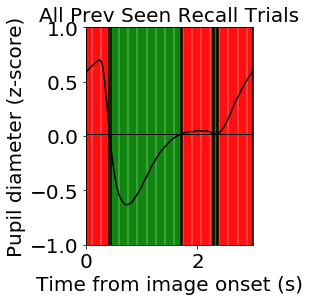

In [18]:
# group gaze data by experiment, participant, time, attention level
attn_group = d_nov.groupby(['Experiment','UniqueID','Time',
                            'Attention Level'], as_index=False).mean()

plt.figure(figsize=(3, 4));  

# group prev seen images by participant and timepoint
data=attn_group[(attn_group['Attention Level'].isin(['Full',
                                                     'Category',
                                                     'Side',
                                                     'None']))].groupby(['UniqueID','Time'], as_index=False).mean()


# sub_mean df has mean across all participants at each timepoint
sub_mean = data.groupby(['Time'],as_index=False).mean()

# obtain pup_mean, the mean pupil value across all timepoints (average of sub_mean)
pup_mean = sub_mean['Interp'].mean()

# label each timepoint in sub_mean as above, below, or equal to pup_mean
sub_mean['mean_divide'] = np.nan
sub_mean.loc[sub_mean['Interp']<pup_mean, 'mean_divide'] = 0
sub_mean.loc[sub_mean['Interp']>pup_mean, 'mean_divide'] = 2
sub_mean.loc[sub_mean['Interp']==pup_mean, 'mean_divide'] = 1
mean_div_list = list(sub_mean['mean_divide'])

# for each labeled timepoint
for idx,x in enumerate(mean_div_list):
    
    # if its label does not match the timepoints immediately to its right and left
    # switch its label to match its neighbors
    if x != mean_div_list[idx-1] and x!= mean_div_list[idx+1]:
        if mean_div_list[idx-1] == mean_div_list[idx+1]:
            mean_div_list[idx] = mean_div_list[idx+1]
            print('fixed one at index:'+str(idx))
        else:
            print("issue!")

# add updated timepoint labels to sub_mean df
sub_mean['mean_divide'] = mean_div_list

# for every row (ie every timepoint) color by timepoint label
for row in sub_mean[sub_mean['mean_divide']==0].iterrows():
    plt.vlines(row[1]['Time'], -1,1, color='green')

for row in sub_mean[sub_mean['mean_divide']==2].iterrows():
    plt.vlines(row[1]['Time'], -1,1, color='red')

for row in sub_mean[sub_mean['mean_divide']==1].iterrows():
    plt.vlines(row[1]['Time'], -1,1, color='black')

# MAKE BINS --> bin timepoints by timepoint labels

# initialize first bin at timepoint 0
bins=[0]

# for each point where labels change, 
# record the two timepoints on noth sides of the switch
for idx,row in sub_mean.iterrows():
    if idx != 0:
        if row['mean_divide']!=sub_mean['mean_divide'][idx-1]:
            bins.append(sub_mean['Time'][idx-1])
            bins.append(row['Time'])

# end last bin at last timepoint
bins.append(3)

# make bin times df and save to csv
key_name = 'Both'; filename = 'all_prev_seen_memory_bins.csv'
bin_df = pd.DataFrame({key_name:bins})
bin_df.to_csv(filename)

# for each bin edgepoint
for b in bins:
    
    # plot a black line
    plt.vlines(b, -1,1, color='black')

# also plot pup_mean as a horizontal line
plt.hlines(pup_mean, 0, 3, color='black', linewidth=1)

# and plot sub_mean as pupillary timecourse
sb.lineplot(x='Time', y='Interp', data=sub_mean, color='black')
plt.title('All Prev Seen Recall Trials', size=20)
plt.xlim((0 , 3)); plt.ylim((-1, 1)); plt.tick_params(labelsize=20)
plt.xlabel("Time from image onset (s)", size = 20); plt.ylabel("Pupil diameter (z-score)", size = 20)

name = 'all_prev_seen_memory_Red_Green.pdf'
plt.savefig(name)
plt.show()

# Figure 3

### Both experiments: mean chunk, prev seen, attn level w/ stats

In [19]:
d_nov['Familiarity'] = np.nan
d_nov.loc[(d_nov['Familiarity Rating']==1) | (d_nov['Familiarity Rating']==2), 'Familiarity'] = 'Unfamiliar'
d_nov.loc[(d_nov['Familiarity Rating']==3) | (d_nov['Familiarity Rating']==4), 'Familiarity'] = 'Familiar'
attn_group = d_nov.groupby(['Experiment','UniqueID','Familiarity','Time','Attention Level'], as_index=False).mean()

Full


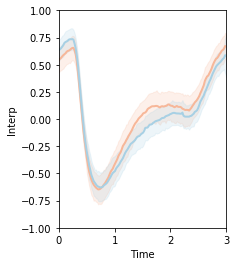



Side


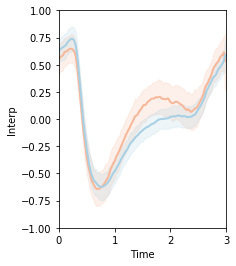



Category


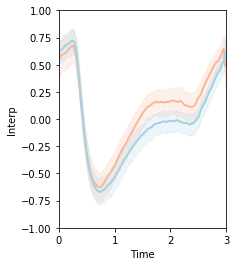

Category chunk 3: 
Ttest_indResult(statistic=2.2552242263059497, pvalue=0.02629854089155663)

Category chunk 4: 
Ttest_indResult(statistic=1.9068006031725437, pvalue=0.05941672911615138)

Category chunk 5: 
Ttest_indResult(statistic=1.8826551334475121, pvalue=0.06265391170655996)



None


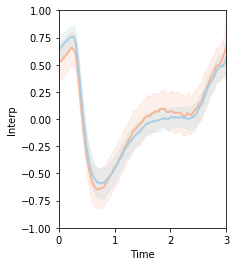

In [20]:
these_bins = pd.read_csv('all_prev_seen_memory_bins.csv')

d_nov_place = d_nov[(d_nov['Attention Level'].isin(['Full','Side','Category','None']))]

attn_group = d_nov_place.groupby(['Experiment','UniqueID','Familiarity', 'Attention Level',
                                  'Time', 'Category'], as_index=False).mean()

for e in ['Full','Side','Category','None']:
    
    print(e) 
        
    data=attn_group[(attn_group['Attention Level']==e)].groupby(['UniqueID','Time',
                                                        'Familiarity'], 
                                                                 as_index=False).mean()

    plt.figure(figsize=(3, 4));
    sb.lineplot(x='Time', y='Interp', data=data, 
                hue='Familiarity', linewidth = 2, 
                palette="RdBu", legend=False)
    
    plt.xlim(0,3); plt.ylim(-1, 1) 
    
    plt.savefig('COMBINED_all_'+e+'_presentation.pdf')
    plt.show()
    # print('Participants total:' + str(len(data['UniqueID'].unique())))
                
    binnies =  these_bins
    binnies = list(binnies['Both'])

    # for each chunk
    chunk_1 = attn_group[(attn_group['Attention Level']==e)&(attn_group['Time']>=binnies[0])
                         &(attn_group['Time']<=binnies[1])]
    chunk_1 = chunk_1.groupby(['UniqueID','Familiarity'], as_index=False).mean()
    
    one = scipy.stats.ttest_ind(chunk_1[chunk_1['Familiarity']=='Familiar']['Interp'],
                                chunk_1[chunk_1['Familiarity']=='Unfamiliar']['Interp'])


    chunk_2 = attn_group[(attn_group['Attention Level']==e)&(attn_group['Time']>=binnies[2])
                         &(attn_group['Time']<=binnies[3])]
    chunk_2 = chunk_2.groupby(['UniqueID','Familiarity'], as_index=False).mean()
    
    two = scipy.stats.ttest_ind(chunk_2[chunk_2['Familiarity']=='Familiar']['Interp'],
                                chunk_2[chunk_2['Familiarity']=='Unfamiliar']['Interp'])
        

    chunk_3 = attn_group[(attn_group['Attention Level']==e)
                         &(attn_group['Time']>=binnies[4])&(attn_group['Time']<=binnies[5])]
    chunk_3 = chunk_3.groupby(['UniqueID','Familiarity'], as_index=False).mean()
    
    three = scipy.stats.ttest_ind(chunk_3[chunk_3['Familiarity']=='Familiar']['Interp'],
                                  chunk_3[chunk_3['Familiarity']=='Unfamiliar']['Interp'])


    chunk_4 = attn_group[(attn_group['Attention Level']==e)
                         &(attn_group['Time']>=binnies[5])&(attn_group['Time']<=binnies[6])]
    chunk_4 = chunk_4.groupby(['UniqueID','Familiarity'], as_index=False).mean()
    
    four = scipy.stats.ttest_ind(chunk_4[chunk_4['Familiarity']=='Familiar']['Interp'],
                                 chunk_4[chunk_4['Familiarity']=='Unfamiliar']['Interp'])

    
    chunk_5 = attn_group[(attn_group['Attention Level']==e)
                         &(attn_group['Time']>=binnies[7])&(attn_group['Time']<=binnies[8])]
    chunk_5 = chunk_5.groupby(['UniqueID','Familiarity'], as_index=False).mean()
    
    five = scipy.stats.ttest_ind(chunk_5[chunk_5['Familiarity']=='Familiar']['Interp'],
                                 chunk_5[chunk_5['Familiarity']=='Unfamiliar']['Interp'])
    
        
    # pairwise t-tests
    # print result
    for t,n in zip([1,2,3,4,5],[one, two, three, four, five]):
        if n.pvalue<=.1:
            print(e+' chunk ' + str(t)+': '); print(n); print()
        
    print();print()

In [21]:
################################

# Plots with full four ratings

################################



# these_bins = pd.read_csv('all_prev_seen_memory_bins.csv')

# d_nov_place = d_nov[(d_nov['Attention Level'].isin(['Full','Side','Category','None']))]

# attn_group = d_nov_place.groupby(['Experiment','UniqueID','Familiarity Rating', 'Attention Level',
#                                   'Time', 'Category'], as_index=False).mean()

# for e in ['Full','Side','Category','None']:
    
#     print(e) 
        
#     data=attn_group[(attn_group['Attention Level']==e)].groupby(['UniqueID','Time',
#                                                         'Familiarity Rating'], 
#                                                                  as_index=False).mean()

#     plt.figure(figsize=(3, 4));
#     sb.lineplot(x='Time', y='Interp', data=data, 
#                 hue='Familiarity Rating', linewidth = 2, 
#                 palette="RdBu", legend=False)
#     plt.show()
#     print('Participants total:' + str(len(data['UniqueID'].unique())))
                
#     binnies =  these_bins
#     binnies = list(binnies['Both'])

#     # for each chunk
#     chunk_1 = attn_group[(attn_group['Attention Level']==e)&(attn_group['Time']>=binnies[0])
#                          &(attn_group['Time']<=binnies[1])]
#     chunk_1 = chunk_1.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()
# #     print('chunk 1, rating 4 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==4]['UniqueID'].unique())))
# #     print('chunk 1, rating 3 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==3]['UniqueID'].unique())))
# #     print('chunk 1, rating 2 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==2]['UniqueID'].unique())))
# #     print('chunk 1, rating 1 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==1]['UniqueID'].unique())))
    
#     for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
#         stat = scipy.stats.ttest_ind(chunk_1[chunk_1['Familiarity Rating']==a[0]]['Interp'],
#                                     chunk_1[chunk_1['Familiarity Rating']==a[1]]['Interp'])
#         if stat.pvalue<=.06:
#             print('chunk 1, '+str(a[0])+" vs "+str(a[1]))
#             print(stat)

#     chunk_2 = attn_group[(attn_group['Attention Level']==e)&(attn_group['Time']>=binnies[2])
#                          &(attn_group['Time']<=binnies[3])]
#     chunk_2 = chunk_2.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()
# #     print('chunk 2, rating 4 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==4]['UniqueID'].unique())))
# #     print('chunk 2, rating 3 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==3]['UniqueID'].unique())))
# #     print('chunk 2, rating 2 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==2]['UniqueID'].unique())))
# #     print('chunk 2, rating 1 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==1]['UniqueID'].unique())))
# #     print()
    
#     for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
#         stat = scipy.stats.ttest_ind(chunk_2[chunk_2['Familiarity Rating']==a[0]]['Interp'],
#                                     chunk_2[chunk_2['Familiarity Rating']==a[1]]['Interp'])
#         if stat.pvalue<=.06:
#             print('chunk 2, '+str(a[0])+" vs "+str(a[1]))
#             print(stat)

#     chunk_3 = attn_group[(attn_group['Attention Level']==e)
#                          &(attn_group['Time']>=binnies[4])&(attn_group['Time']<=binnies[5])]
#     chunk_3 = chunk_3.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()
    
# #     print('chunk 3, rating 4 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==4]['UniqueID'].unique())))
# #     print('chunk 3, rating 3 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==3]['UniqueID'].unique())))
# #     print('chunk 3, rating 2 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==2]['UniqueID'].unique())))
# #     print('chunk 3, rating 1 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==1]['UniqueID'].unique())))
# #     print()
    
#     for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
#         stat = scipy.stats.ttest_ind(chunk_3[chunk_3['Familiarity Rating']==a[0]]['Interp'],
#                                     chunk_3[chunk_3['Familiarity Rating']==a[1]]['Interp'])
#         if stat.pvalue<=.06:
#             print('chunk 3, '+str(a[0])+" vs "+str(a[1]))
#             print(stat)

#     chunk_4 = attn_group[(attn_group['Attention Level']==e)
#                          &(attn_group['Time']>=binnies[5])&(attn_group['Time']<=binnies[6])]
#     chunk_4 = chunk_4.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()
    
# #     print('chunk 4, rating 4 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==4]['UniqueID'].unique())))
# #     print('chunk 4, rating 3 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==3]['UniqueID'].unique())))
# #     print('chunk 4, rating 2 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==2]['UniqueID'].unique())))
# #     print('chunk 4, rating 1 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==1]['UniqueID'].unique())))
# #     print()
    
#     for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
#         stat = scipy.stats.ttest_ind(chunk_4[chunk_4['Familiarity Rating']==a[0]]['Interp'],
#                                 chunk_4[chunk_4['Familiarity Rating']==a[1]]['Interp'])
#     if stat.pvalue<=.06:
#         print('chunk 4, '+str(a[0])+" vs "+str(a[1]))
#         print(stat)

#     chunk_5 = attn_group[(attn_group['Attention Level']==e)
#                          &(attn_group['Time']>=binnies[7])&(attn_group['Time']<=binnies[8])]
#     chunk_5 = chunk_5.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()
    
# #     print('chunk 5, rating 4 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==4]['UniqueID'].unique())))
# #     print('chunk 5, rating 3 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==3]['UniqueID'].unique())))
# #     print('chunk 5, rating 2 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==2]['UniqueID'].unique())))
# #     print('chunk 5, rating 1 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==1]['UniqueID'].unique())))
# #     print()
    
#     for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
#         stat = scipy.stats.ttest_ind(chunk_5[chunk_5['Familiarity Rating']==a[0]]['Interp'],
#                                 chunk_5[chunk_5['Familiarity Rating']==a[1]]['Interp'])
#     if stat.pvalue<=.06:
        
#         print('chunk 5, '+str(a[0])+" vs "+str(a[1]))
#         print(stat)
        
#     print();print()


### Each experiment: mean chunk, prev seen, attn level w/ stats (Supplement 3 & 4)

Sustained Full


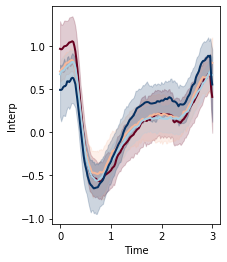

chunk 1, 1 vs 4
Ttest_indResult(statistic=2.004476584912481, pvalue=0.05044981989880756)


Sustained Side


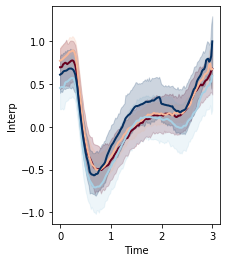

chunk 1, 2 vs 3
Ttest_indResult(statistic=2.2268605193212494, pvalue=0.03048967795611556)


Sustained Category


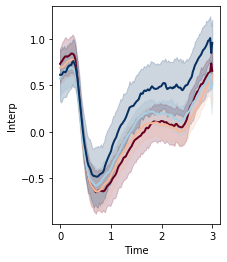

chunk 2, 1 vs 4
Ttest_indResult(statistic=-1.7384192972553238, pvalue=0.08882711426092636)
chunk 3, 1 vs 4
Ttest_indResult(statistic=-2.245066818487728, pvalue=0.02961365916571514)
chunk 3, 2 vs 4
Ttest_indResult(statistic=-2.6284632368926073, pvalue=0.011362801042581623)
chunk 3, 3 vs 4
Ttest_indResult(statistic=-1.9457085280172275, pvalue=0.057322019673162444)
chunk 4, 3 vs 4
Ttest_indResult(statistic=-2.212541623200074, pvalue=0.031620149562675316)
Sustained chunk 5, 3 vs 4
Ttest_indResult(statistic=-2.2362536360294505, pvalue=0.029920897612995996)


Sustained None


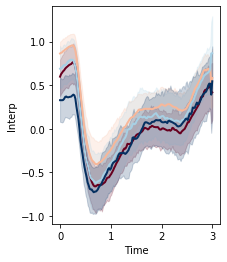

chunk 1, 1 vs 4
Ttest_indResult(statistic=2.0084367849552005, pvalue=0.05121453530307412)
chunk 1, 2 vs 4
Ttest_indResult(statistic=4.150076537741891, pvalue=0.0001586117611506104)
chunk 1, 3 vs 4
Ttest_indResult(statistic=2.1224612075668006, pvalue=0.04037420138776634)
chunk 3, 1 vs 2
Ttest_indResult(statistic=-1.7400797365405916, pvalue=0.08787672752140624)


Variable Full


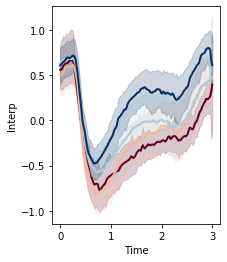

chunk 2, 1 vs 4
Ttest_indResult(statistic=-3.4437929330303048, pvalue=0.0014410932136040585)
chunk 2, 2 vs 4
Ttest_indResult(statistic=-3.0957312243785733, pvalue=0.003677347181621125)
chunk 3, 1 vs 4
Ttest_indResult(statistic=-3.825458800097766, pvalue=0.0004856598597539794)
chunk 3, 2 vs 4
Ttest_indResult(statistic=-2.24368050279237, pvalue=0.03075993411800045)


Variable Side


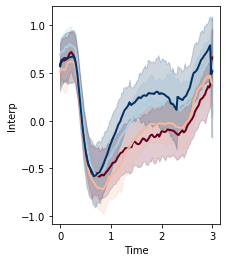

chunk 2, 2 vs 4
Ttest_indResult(statistic=-1.754105518997897, pvalue=0.08842314089400514)
chunk 3, 1 vs 3
Ttest_indResult(statistic=-1.721580983920797, pvalue=0.09372942294677655)
chunk 3, 1 vs 4
Ttest_indResult(statistic=-1.695573063531283, pvalue=0.09998960487546817)


Variable Category


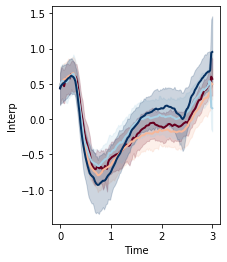

chunk 3, 2 vs 4
Ttest_indResult(statistic=-1.7151598773139478, pvalue=0.09598580173091995)


Variable None


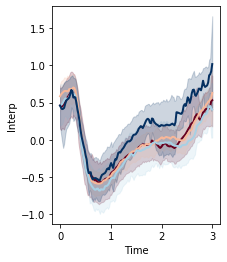

chunk 4, 3 vs 4
Ttest_indResult(statistic=-1.8673659607742494, pvalue=0.07049146024545126)
Variable chunk 5, 3 vs 4
Ttest_indResult(statistic=-2.3668726377797187, pvalue=0.023774614868845256)




In [27]:
these_bins = pd.read_csv('all_prev_seen_memory_bins.csv')

d_nov_place = d_nov[(d_nov['Attention Level'].isin(['Full','Side','Category','None']))]

attn_group = d_nov_place.groupby(['Experiment','UniqueID','Familiarity Rating', 'Attention Level',
                                  'Time', 'Category'], as_index=False).mean()

for exp in ['Sustained','Variable']:
    for e in ['Full','Side','Category','None']:

        print(exp+' '+e) 

        data=attn_group[(attn_group['Attention Level']==e)
                       &(attn_group['Experiment']==exp)].groupby(['UniqueID','Time',
                                                            'Familiarity Rating'], 
                                                                     as_index=False).mean()

        plt.figure(figsize=(3, 4));
        sb.lineplot(x='Time', y='Interp', data=data, 
                    hue='Familiarity Rating', linewidth = 2, 
                    palette="RdBu", legend=False)
        plt.show()
        # print('Participants total:' + str(len(data['UniqueID'].unique())))

        binnies =  these_bins
        binnies = list(binnies['Both'])

        # for each chunk
        chunk_1 = attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)
                             &(attn_group['Time']>=binnies[0])
                             &(attn_group['Time']<=binnies[1])]
        chunk_1 = chunk_1.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()
    #     print('chunk 1, rating 4 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==4]['UniqueID'].unique())))
    #     print('chunk 1, rating 3 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==3]['UniqueID'].unique())))
    #     print('chunk 1, rating 2 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==2]['UniqueID'].unique())))
    #     print('chunk 1, rating 1 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==1]['UniqueID'].unique())))

        for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
            stat = scipy.stats.ttest_ind(chunk_1[chunk_1['Familiarity Rating']==a[0]]['Interp'],
                                        chunk_1[chunk_1['Familiarity Rating']==a[1]]['Interp'])
            if stat.pvalue<=.1:
                print('chunk 1, '+str(a[0])+" vs "+str(a[1]))
                print(stat)

        chunk_2 = attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)&(attn_group['Time']>=binnies[2])
                             &(attn_group['Time']<=binnies[3])]
        chunk_2 = chunk_2.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()
    #     print('chunk 2, rating 4 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==4]['UniqueID'].unique())))
    #     print('chunk 2, rating 3 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==3]['UniqueID'].unique())))
    #     print('chunk 2, rating 2 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==2]['UniqueID'].unique())))
    #     print('chunk 2, rating 1 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==1]['UniqueID'].unique())))
    #     print()

        for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
            stat = scipy.stats.ttest_ind(chunk_2[chunk_2['Familiarity Rating']==a[0]]['Interp'],
                                        chunk_2[chunk_2['Familiarity Rating']==a[1]]['Interp'])
            if stat.pvalue<=.1:
                print('chunk 2, '+str(a[0])+" vs "+str(a[1]))
                print(stat)

        chunk_3 = attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)
                             &(attn_group['Time']>=binnies[4])&(attn_group['Time']<=binnies[5])]
        chunk_3 = chunk_3.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

    #     print('chunk 3, rating 4 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==4]['UniqueID'].unique())))
    #     print('chunk 3, rating 3 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==3]['UniqueID'].unique())))
    #     print('chunk 3, rating 2 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==2]['UniqueID'].unique())))
    #     print('chunk 3, rating 1 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==1]['UniqueID'].unique())))
    #     print()

        for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
            stat = scipy.stats.ttest_ind(chunk_3[chunk_3['Familiarity Rating']==a[0]]['Interp'],
                                        chunk_3[chunk_3['Familiarity Rating']==a[1]]['Interp'])
            if stat.pvalue<=.1:
                print('chunk 3, '+str(a[0])+" vs "+str(a[1]))
                print(stat)

        chunk_4 = attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)
                             &(attn_group['Time']>=binnies[5])&(attn_group['Time']<=binnies[6])]
        chunk_4 = chunk_4.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

    #     print('chunk 4, rating 4 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==4]['UniqueID'].unique())))
    #     print('chunk 4, rating 3 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==3]['UniqueID'].unique())))
    #     print('chunk 4, rating 2 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==2]['UniqueID'].unique())))
    #     print('chunk 4, rating 1 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==1]['UniqueID'].unique())))
    #     print()

        for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
            stat = scipy.stats.ttest_ind(chunk_4[chunk_4['Familiarity Rating']==a[0]]['Interp'],
                                    chunk_4[chunk_4['Familiarity Rating']==a[1]]['Interp'])
        if stat.pvalue<=.1:
            print('chunk 4, '+str(a[0])+" vs "+str(a[1]))
            print(stat)

        chunk_5 = attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)&(attn_group['Attention Level']==e)
                             &(attn_group['Time']>=binnies[7])&(attn_group['Time']<=binnies[8])]
        chunk_5 = chunk_5.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

    #     print('chunk 5, rating 4 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==4]['UniqueID'].unique())))
    #     print('chunk 5, rating 3 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==3]['UniqueID'].unique())))
    #     print('chunk 5, rating 2 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==2]['UniqueID'].unique())))
    #     print('chunk 5, rating 1 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==1]['UniqueID'].unique())))
    #     print()

        for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
            stat = scipy.stats.ttest_ind(chunk_5[chunk_5['Familiarity Rating']==a[0]]['Interp'],
                                    chunk_5[chunk_5['Familiarity Rating']==a[1]]['Interp'])
        if stat.pvalue<=.1:

            print(exp+' chunk 5, '+str(a[0])+" vs "+str(a[1]))
            print(stat)

        print();print()

### Both experiments: mean chunking for novel images

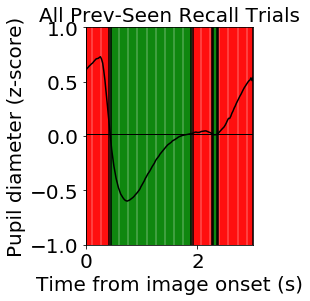

In [49]:
# group gaze data by experiment, participant, time, attention level
attn_group = d_nov.groupby(['Experiment','UniqueID','Time',
                            'Attention Level'], as_index=False).mean()

plt.figure(figsize=(3, 4));  

# group prev seen images by participant and timepoint
data=attn_group[(attn_group['Attention Level'].isin(['Novel_Cued_Cat',
                                                    'Novel_Uncued_Cat']))].groupby(['UniqueID','Time'], as_index=False).mean()

# sub_mean df has mean across all participants at each timepoint
sub_mean = data.groupby(['Time'],as_index=False).mean()

# obtain pup_mean, the mean pupil value across all timepoints (average of sub_mean)
pup_mean = sub_mean['Interp'].mean()

# label each timepoint in sub_mean as above, below, or equal to pup_mean
sub_mean['mean_divide'] = np.nan
sub_mean.loc[sub_mean['Interp']<pup_mean, 'mean_divide']  = 0
sub_mean.loc[sub_mean['Interp']>pup_mean, 'mean_divide']  = 2
sub_mean.loc[sub_mean['Interp']==pup_mean, 'mean_divide'] = 1
mean_div_list = list(sub_mean['mean_divide'])

# for each labeled timepoint
for idx,x in enumerate(mean_div_list):
    
    # if its label does not match the timepoints immediately to its right and left
    # switch its label to match its neighbors
    if x != mean_div_list[idx-1] and x!= mean_div_list[idx+1]:
        if mean_div_list[idx-1] == mean_div_list[idx+1]:
            mean_div_list[idx] = mean_div_list[idx+1]
            print('fixed one at index:'+str(idx))
        else:
            print("issue!")

# add updated timepoint labels to sub_mean df
sub_mean['mean_divide'] = mean_div_list

# for every row (ie every timepoint) color by timepoint label
for row in sub_mean[sub_mean['mean_divide']==0].iterrows():
    plt.vlines(row[1]['Time'], -1,1, color='green')

for row in sub_mean[sub_mean['mean_divide']==2].iterrows():
    plt.vlines(row[1]['Time'], -1,1, color='red')

for row in sub_mean[sub_mean['mean_divide']==1].iterrows():
    plt.vlines(row[1]['Time'], -1,1, color='black')

# MAKE BINS --> bin timepoints by timepoint labels

# initialize first bin at timepoint 0
bins=[0]

# for each point where labels change, 
# record the two timepoints on noth sides of the switch
for idx,row in sub_mean.iterrows():
    if idx != 0:
        if row['mean_divide']!=sub_mean['mean_divide'][idx-1]:
            bins.append(sub_mean['Time'][idx-1])
            bins.append(row['Time'])

# end last bin at last timepoint
bins.append(3)

# make bin times df and save to csv
key_name = 'Both'; filename = 'all_novel_memory_bins.csv'
bin_df = pd.DataFrame({key_name:bins})
bin_df.to_csv(filename)

# for each bin edgepoint
for b in bins:
    
    # plot a black line
    plt.vlines(b, -1,1, color='black')

# also plot pup_mean as a horizontal line
plt.hlines(pup_mean, 0, 3, color='black', linewidth=1)

# and plot sub_mean as pupillary timecourse
sb.lineplot(x='Time', y='Interp', data=sub_mean, color='black')
plt.title('All Prev-Seen Recall Trials', size=20)
plt.xlim((0 , 3)); plt.ylim((-1, 1)); plt.tick_params(labelsize=20)
plt.xlabel("Time from image onset (s)", size = 20); plt.ylabel("Pupil diameter (z-score)", size = 20)

name = 'all_novel_memory_Red_Green.pdf'
plt.savefig(name)
plt.show()

# Figure 4

### Both experiments: mean chunk, novel, category w/ stats

Face
Novel_Cued_Cat



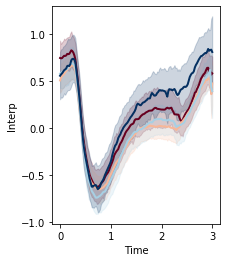

chunk 3, 2 vs 4
Ttest_indResult(statistic=-2.8783853934091708, pvalue=0.005187926180822726)
chunk 3, 3 vs 4
Ttest_indResult(statistic=-2.226501778581539, pvalue=0.02902399297019491)
chunk 4, 3 vs 4
Ttest_indResult(statistic=-2.5136089287797607, pvalue=0.01412553732844248)
chunk 5, 3 vs 4
Ttest_indResult(statistic=-2.3661200101552726, pvalue=0.020595102716108225)


Place
Novel_Cued_Cat



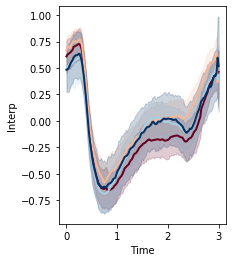

chunk 3, 1 vs 2
Ttest_indResult(statistic=-1.6742055867465124, pvalue=0.09752402725654716)


Face
Novel_Uncued_Cat



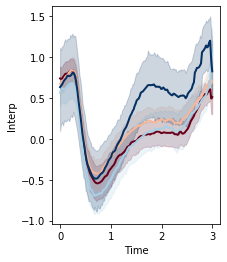

chunk 2, 3 vs 4
Ttest_indResult(statistic=-1.7430286662698684, pvalue=0.08628622922993781)
chunk 3, 1 vs 4
Ttest_indResult(statistic=-2.9091682698284855, pvalue=0.004892587915194569)
chunk 3, 2 vs 4
Ttest_indResult(statistic=-2.108821066913671, pvalue=0.038439230289903994)
chunk 3, 3 vs 4
Ttest_indResult(statistic=-2.3070498637560184, pvalue=0.02440556297926101)
chunk 4, 3 vs 4
Ttest_indResult(statistic=-2.1936564525622635, pvalue=0.032018151522164695)
chunk 5, 3 vs 4
Ttest_indResult(statistic=-1.976654892888354, pvalue=0.05253293302502579)


Place
Novel_Uncued_Cat



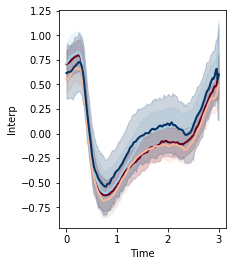

In [46]:
these_bins = pd.read_csv('all_novel_memory_bins.csv')

d_nov_place = d_nov[d_nov['Attention Level'].isin(['Novel_Cued_Cat',
                                                    'Novel_Uncued_Cat'])]

attn_group = d_nov_place.groupby(['Experiment',
                                  'UniqueID',
                                  'Familiarity Rating',
                                  'Attention Level',
                                  'Time', 'Category'], as_index=False).mean()

for e in ['Novel_Cued_Cat','Novel_Uncued_Cat']:
    for cat in ['Face','Place']:
    
        print(cat); print(e)

        data=attn_group[(attn_group['Attention Level']==e)&(attn_group['Category']==cat)].groupby(['UniqueID','Time',
                                                            'Familiarity Rating'], 
                                                                     as_index=False).mean()
        
        #print('Participants total:' + str(len(data['UniqueID'].unique())))
        print()
        
        plt.figure(figsize=(3, 4));
        sb.lineplot(x='Time', y='Interp', data=data, 
                    hue='Familiarity Rating', linewidth = 2, 
                    palette="RdBu", legend=False)
        plt.show()

        binnies =  these_bins
        binnies =  list(binnies['Both'])

        # for each chunk
        chunk_1 = attn_group[(attn_group['Attention Level']==e)&(attn_group['Time']>=binnies[0])
                             &(attn_group['Time']<=binnies[1])&(attn_group['Category']==cat)]
        chunk_1 = chunk_1.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

#         print('chunk 1, rating 4 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==4]['UniqueID'].unique())))
#         print('chunk 1, rating 3 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==3]['UniqueID'].unique())))
#         print('chunk 1, rating 2 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==2]['UniqueID'].unique())))
#         print('chunk 1, rating 1 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==1]['UniqueID'].unique())))


        for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
            stat = scipy.stats.ttest_ind(chunk_1[chunk_1['Familiarity Rating']==a[0]]['Interp'],
                                        chunk_1[chunk_1['Familiarity Rating']==a[1]]['Interp'])
            if stat.pvalue<=.1:
                print('chunk 1, '+str(a[0])+" vs "+str(a[1]))
                print(stat)

        chunk_2 = attn_group[(attn_group['Attention Level']==e)&(attn_group['Time']>=binnies[2])
                             &(attn_group['Time']<=binnies[3])&(attn_group['Category']==cat)]
        chunk_2 = chunk_2.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()
        
#         print('chunk 2, rating 4 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==4]['UniqueID'].unique())))
#         print('chunk 2, rating 3 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==3]['UniqueID'].unique())))
#         print('chunk 2, rating 2 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==2]['UniqueID'].unique())))
#         print('chunk 2, rating 1 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==1]['UniqueID'].unique())))
#         print()
    

        for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
            stat = scipy.stats.ttest_ind(chunk_2[chunk_2['Familiarity Rating']==a[0]]['Interp'],
                                        chunk_2[chunk_2['Familiarity Rating']==a[1]]['Interp'])
            if stat.pvalue<=.1:
                print('chunk 2, '+str(a[0])+" vs "+str(a[1]))
                print(stat)

        chunk_3 = attn_group[(attn_group['Attention Level']==e)
                             &(attn_group['Time']>=binnies[4])&(attn_group['Category']==cat)&(attn_group['Time']<=binnies[5])]
        chunk_3 = chunk_3.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

#         print('chunk 3, rating 4 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==4]['UniqueID'].unique())))
#         print('chunk 3, rating 3 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==3]['UniqueID'].unique())))
#         print('chunk 3, rating 2 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==2]['UniqueID'].unique())))
#         print('chunk 3, rating 1 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==1]['UniqueID'].unique())))
#         print()
    
        
        for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
            stat = scipy.stats.ttest_ind(chunk_3[chunk_3['Familiarity Rating']==a[0]]['Interp'],
                                        chunk_3[chunk_3['Familiarity Rating']==a[1]]['Interp'])
            if stat.pvalue<=.1:
                print('chunk 3, '+str(a[0])+" vs "+str(a[1]))
                print(stat)

        chunk_4 = attn_group[(attn_group['Attention Level']==e)
                             &(attn_group['Time']>=binnies[5])&(attn_group['Category']==cat)&(attn_group['Time']<=binnies[6])]
        chunk_4 = chunk_4.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

#         print('chunk 4, rating 4 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==4]['UniqueID'].unique())))
#         print('chunk 4, rating 3 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==3]['UniqueID'].unique())))
#         print('chunk 4, rating 2 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==2]['UniqueID'].unique())))
#         print('chunk 4, rating 1 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==1]['UniqueID'].unique())))
#         print()
        
        for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
            stat = scipy.stats.ttest_ind(chunk_4[chunk_4['Familiarity Rating']==a[0]]['Interp'],
                                    chunk_4[chunk_4['Familiarity Rating']==a[1]]['Interp'])
        if stat.pvalue<=.1:
            print('chunk 4, '+str(a[0])+" vs "+str(a[1]))
            print(stat)

        chunk_5 = attn_group[(attn_group['Attention Level']==e)
                             &(attn_group['Time']>=binnies[7])&(attn_group['Category']==cat)&(attn_group['Time']<=binnies[8])]
        chunk_5 = chunk_5.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()
        
#         print('chunk 5, rating 4 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==4]['UniqueID'].unique())))
#         print('chunk 5, rating 3 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==3]['UniqueID'].unique())))
#         print('chunk 5, rating 2 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==2]['UniqueID'].unique())))
#         print('chunk 5, rating 1 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==1]['UniqueID'].unique())))
#         print()

        for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
            stat = scipy.stats.ttest_ind(chunk_5[chunk_5['Familiarity Rating']==a[0]]['Interp'],
                                    chunk_5[chunk_5['Familiarity Rating']==a[1]]['Interp'])
        if stat.pvalue<=.1:

            print('chunk 5, '+str(a[0])+" vs "+str(a[1]))
            print(stat)

        print();print()


### Each experiment: mean chunk, novel, category w/ stats (Supplement 5 & 6)

Sustained
Face
Novel_Cued_Cat



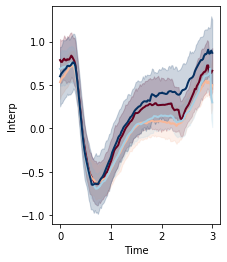

chunk 3, 2 vs 4
Ttest_indResult(statistic=-1.9613854241063722, pvalue=0.05603903606439999)
chunk 4, 3 vs 4
Ttest_indResult(statistic=-1.965057640723581, pvalue=0.05588904898261012)
chunk 5, 3 vs 4
Ttest_indResult(statistic=-1.850709672544655, pvalue=0.07108876082500257)


Sustained
Place
Novel_Cued_Cat



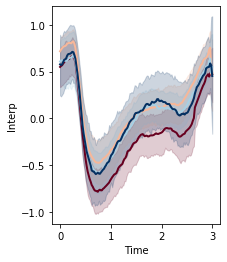

chunk 2, 1 vs 2
Ttest_indResult(statistic=-1.9711345196736831, pvalue=0.05404119609900749)
chunk 2, 1 vs 3
Ttest_indResult(statistic=-1.710834923704337, pvalue=0.09307179984333036)
chunk 3, 1 vs 2
Ttest_indResult(statistic=-1.77033698583977, pvalue=0.08253311845870014)


Sustained
Face
Novel_Uncued_Cat



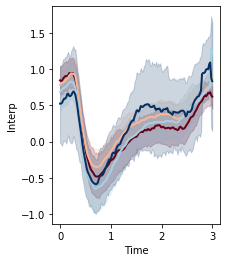



Sustained
Place
Novel_Uncued_Cat



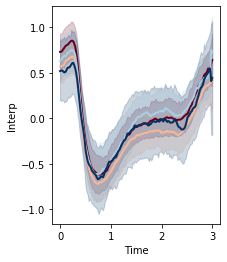



Variable
Face
Novel_Cued_Cat



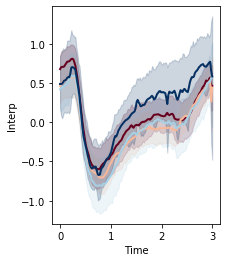

chunk 3, 2 vs 4
Ttest_indResult(statistic=-2.1343899646794378, pvalue=0.041391377775492365)


Variable
Place
Novel_Cued_Cat



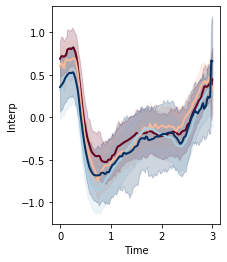



Variable
Face
Novel_Uncued_Cat



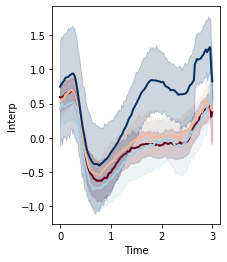

chunk 2, 1 vs 4
Ttest_indResult(statistic=-1.7474642011703658, pvalue=0.091139908348016)
chunk 2, 3 vs 4
Ttest_indResult(statistic=-1.7879098915119023, pvalue=0.08461902569766995)
chunk 3, 1 vs 4
Ttest_indResult(statistic=-3.9441741299820205, pvalue=0.00046545169821277744)
chunk 3, 2 vs 4
Ttest_indResult(statistic=-3.0875424122199453, pvalue=0.00431929885764453)
chunk 3, 3 vs 4
Ttest_indResult(statistic=-2.890733009526699, pvalue=0.007347320225980557)
chunk 4, 3 vs 4
Ttest_indResult(statistic=-2.5880065569021653, pvalue=0.015133628448549019)
chunk 5, 3 vs 4
Ttest_indResult(statistic=-2.3785497516420393, pvalue=0.024440370187808255)


Variable
Place
Novel_Uncued_Cat



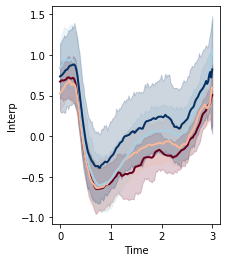

chunk 3, 1 vs 4
Ttest_indResult(statistic=-1.8288480419261839, pvalue=0.07809306467145684)




In [47]:
these_bins = pd.read_csv('all_novel_memory_bins.csv')

d_nov_place = d_nov[d_nov['Attention Level'].isin(['Novel_Cued_Cat',
                                                    'Novel_Uncued_Cat'])]

attn_group = d_nov_place.groupby(['Experiment',
                                  'UniqueID',
                                  'Familiarity Rating',
                                  'Attention Level',
                                  'Time', 'Category'], as_index=False).mean()

for exp in ['Sustained', 'Variable']:
    for e in ['Novel_Cued_Cat','Novel_Uncued_Cat']:
        for cat in ['Face','Place']:

            print(exp); print(cat); print(e)

            data=attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)&(attn_group['Category']==cat)].groupby(['UniqueID','Time',
                                                                'Familiarity Rating'], 
                                                                         as_index=False).mean()

            #print('Participants total:' + str(len(data['UniqueID'].unique())))
            print()

            plt.figure(figsize=(3, 4));
            sb.lineplot(x='Time', y='Interp', data=data, 
                        hue='Familiarity Rating', linewidth = 2, 
                        palette="RdBu", legend=False)
            plt.show()

            binnies =  these_bins
            binnies =  list(binnies['Both'])

            # for each chunk
            chunk_1 = attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)&(attn_group['Time']>=binnies[0])
                                 &(attn_group['Time']<=binnies[1])&(attn_group['Category']==cat)]
            chunk_1 = chunk_1.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

    #         print('chunk 1, rating 4 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==4]['UniqueID'].unique())))
    #         print('chunk 1, rating 3 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==3]['UniqueID'].unique())))
    #         print('chunk 1, rating 2 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==2]['UniqueID'].unique())))
    #         print('chunk 1, rating 1 participants: '+str(len(chunk_1[chunk_1['Familiarity Rating']==1]['UniqueID'].unique())))


            for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
                stat = scipy.stats.ttest_ind(chunk_1[chunk_1['Familiarity Rating']==a[0]]['Interp'],
                                            chunk_1[chunk_1['Familiarity Rating']==a[1]]['Interp'])
                if stat.pvalue<=.1:
                    print('chunk 1, '+str(a[0])+" vs "+str(a[1]))
                    print(stat)

            chunk_2 = attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)&(attn_group['Time']>=binnies[2])
                                 &(attn_group['Time']<=binnies[3])&(attn_group['Category']==cat)]
            chunk_2 = chunk_2.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

    #         print('chunk 2, rating 4 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==4]['UniqueID'].unique())))
    #         print('chunk 2, rating 3 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==3]['UniqueID'].unique())))
    #         print('chunk 2, rating 2 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==2]['UniqueID'].unique())))
    #         print('chunk 2, rating 1 participants: '+str(len(chunk_2[chunk_2['Familiarity Rating']==1]['UniqueID'].unique())))
    #         print()


            for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
                stat = scipy.stats.ttest_ind(chunk_2[chunk_2['Familiarity Rating']==a[0]]['Interp'],
                                            chunk_2[chunk_2['Familiarity Rating']==a[1]]['Interp'])
                if stat.pvalue<=.1:
                    print('chunk 2, '+str(a[0])+" vs "+str(a[1]))
                    print(stat)

            chunk_3 = attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)
                                 &(attn_group['Time']>=binnies[4])&(attn_group['Category']==cat)&(attn_group['Time']<=binnies[5])]
            chunk_3 = chunk_3.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

    #         print('chunk 3, rating 4 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==4]['UniqueID'].unique())))
    #         print('chunk 3, rating 3 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==3]['UniqueID'].unique())))
    #         print('chunk 3, rating 2 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==2]['UniqueID'].unique())))
    #         print('chunk 3, rating 1 participants: '+str(len(chunk_3[chunk_3['Familiarity Rating']==1]['UniqueID'].unique())))
    #         print()


            for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
                stat = scipy.stats.ttest_ind(chunk_3[chunk_3['Familiarity Rating']==a[0]]['Interp'],
                                            chunk_3[chunk_3['Familiarity Rating']==a[1]]['Interp'])
                if stat.pvalue<=.1:
                    print('chunk 3, '+str(a[0])+" vs "+str(a[1]))
                    print(stat)

            chunk_4 = attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)
                                 &(attn_group['Time']>=binnies[5])&(attn_group['Category']==cat)&(attn_group['Time']<=binnies[6])]
            chunk_4 = chunk_4.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

    #         print('chunk 4, rating 4 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==4]['UniqueID'].unique())))
    #         print('chunk 4, rating 3 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==3]['UniqueID'].unique())))
    #         print('chunk 4, rating 2 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==2]['UniqueID'].unique())))
    #         print('chunk 4, rating 1 participants: '+str(len(chunk_4[chunk_4['Familiarity Rating']==1]['UniqueID'].unique())))
    #         print()

            for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
                stat = scipy.stats.ttest_ind(chunk_4[chunk_4['Familiarity Rating']==a[0]]['Interp'],
                                        chunk_4[chunk_4['Familiarity Rating']==a[1]]['Interp'])
            if stat.pvalue<=.1:
                print('chunk 4, '+str(a[0])+" vs "+str(a[1]))
                print(stat)

            chunk_5 = attn_group[(attn_group['Experiment']==exp)&(attn_group['Attention Level']==e)
                                 &(attn_group['Time']>=binnies[7])&(attn_group['Category']==cat)&(attn_group['Time']<=binnies[8])]
            chunk_5 = chunk_5.groupby(['UniqueID','Familiarity Rating'], as_index=False).mean()

    #         print('chunk 5, rating 4 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==4]['UniqueID'].unique())))
    #         print('chunk 5, rating 3 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==3]['UniqueID'].unique())))
    #         print('chunk 5, rating 2 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==2]['UniqueID'].unique())))
    #         print('chunk 5, rating 1 participants: '+str(len(chunk_5[chunk_5['Familiarity Rating']==1]['UniqueID'].unique())))
    #         print()

            for a in [(1,2), (1,3), (1,4), (2,3), (2,4), (3, 4)]:
                stat = scipy.stats.ttest_ind(chunk_5[chunk_5['Familiarity Rating']==a[0]]['Interp'],
                                        chunk_5[chunk_5['Familiarity Rating']==a[1]]['Interp'])
            if stat.pvalue<=.1:

                print('chunk 5, '+str(a[0])+" vs "+str(a[1]))
                print(stat)

            print();print()